# OpenFOAM Slice Analysis

This program extracts data from Paraview slices of grids, interpolates them, and computes L2 norm, etc.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 08/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import glob, gzip, tqdm, os

X0 slices are computed by taking a plane parallel to the nozzle axis at the symmetry line of the domain.

All other slices are computed by taking a plane normal to the nozzle axis at a fixed streamwise station.

Computation process is the same for all planes:
1. Take threshold yMean <= 0.99 (removing pure air regions)
2. Transform geometry to ensure (0,0,0) is the middle of the nozzle exit for all grids
3. Take a slice
4. Compute a new field 'noz' which reflects which grid we are using
5. Merge all datasets for noz1...noz9 and save this for a single fluid.

In [46]:
# This specifies how we describe the sorting keys.
# For a convergence study, it is D/delta. (orifice to cell width ratio)
cellLengths=[2.52e-4,1.26e-4,6.13e-5,3.13e-5,1.58e-5]
keyDescriptors=np.round(0.318e-3/np.array(cellLengths),2)
print(keyDescriptors)

[ 1.26  2.52  5.19 10.16 20.13]


## Function to read slice CSV

In [2]:
def read_slice_csv(filename):
    if filename[-3:].lower() == '.gz': fileReader=gzip.open
    else: fileReader=open
           
    print("Scanning "+filename+"...")
    with fileReader(filename,'r') as F:
        Nlines=len(F.readlines())
    
    with fileReader(filename,'r') as F:
        print("Reading data...")
        varNames = F.readline().strip().replace('"','').split(',')
        data = np.ndarray((len(varNames),Nlines-1))
        for n in tqdm.tqdm(range(Nlines-1)):
            d = F.readline().strip().replace('"','').split(',')
            data[:,n] = [float(d_) for d_ in d]
        
    return data, varNames

In [3]:
#topLevel = "/mnt/internal-hdd/2021_pmdi/newGeomTrial/postProcessing/slices/"
topLevel = "/mnt/internal/2021_pmdi/newGeomTrial/postProcessing/convergence/"

D,V=read_slice_csv(topLevel+"conv_fromVtm.csv")
print("dataset size: "+str(D.shape))

Scanning /mnt/internal/2021_pmdi/newGeomTrial/postProcessing/convergence/conv_fromVtm.csv...
Reading data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510712/510712 [00:15<00:00, 33692.09it/s]

dataset size: (66, 510712)


## Sort data combined in single CSV using a flag field
if GroupDatasets was used in Paraview with some field being a flag to indicate which data points are from which grids, we can split them apart.

In [4]:
sortingKey = 'resolution'

# Get the possible values of the sorting key and which column it is in.
keyIndex = V.index(sortingKey)
keyValues = np.unique(D[keyIndex,:])

# Find the largest number of gridpoints for any possible sorting key value
npts = 0
nmin = np.inf
kmin = None
for k in keyValues:
    n = np.sum(D[keyIndex,:]==k)
    if n>npts:
        npts=n
    if n<nmin: 
        nmin=n
        kmin=k
    print("Sorting index [%i] : %i gridpoints" %(k,n) )
    
# Move data to new array.
Ds = np.ndarray((len(keyValues), len(V), npts))
Ds[...] = np.nan
for j in tqdm.tqdm(range(len(keyValues))):
    i = D[keyIndex,:]==keyValues[j]
    Ds[j, :, :np.sum(i)] = D[:, i]


print("Moved %s -> %s" % (D.shape, Ds.shape))

Sorting index [1] : 39067 gridpoints
Sorting index [2] : 57278 gridpoints
Sorting index [3] : 127523 gridpoints
Sorting index [4] : 133630 gridpoints
Sorting index [5] : 153214 gridpoints


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.06it/s]

Moved (66, 510712) -> (5, 66, 153214)


## Interpolate data onto a uniform grid

In [5]:
import scipy.interpolate, scipy.spatial


def interpolateFunction(d, xy_input_indices, xy_output, pbar=None):
    """ Dan's function to run the interpolation on the last axis of a 2d array with the 1st axis
    being independent variables."""
    
    # Get coordinates of input data
    valid = ~np.isnan(d[xy_input_indices[0],:]) # X is not NaN
    xy_input = [ d[i,valid] for i in xy_input_indices ]
    
    # Precompute Delaunay triangulation - will be same for every variable.
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
    points = scipy.spatial.Delaunay(np.transpose(np.array(xy_input)), furthest_site=False,\
                                    incremental=False, qhull_options=None)
    
    # Loop variables
    interpolatedResult = []
    for i in range(d.shape[0]): 
        if not i in xy_input_indices: # Interpolate data for non coord variable
            #https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html            
            fInt = scipy.interpolate.LinearNDInterpolator(points, d[i,valid], fill_value=np.nan, rescale=False)
            interpolatedResult.append(fInt(xy_output[0], xy_output[1]))
            
        elif i == xy_input_indices[0]: # Copy coordinates directly
            interpolatedResult.append(xy_output[0])
        elif i == xy_input_indices[1]: # Copy coordinates directly
            interpolatedResult.append(xy_output[1])
        else:
            raise IndexError
            
        if pbar is not None: pbar.update(d.shape[-1])
        
    return np.array(interpolatedResult)


In [6]:
# Specify the variables containing the coordinates of grid points
xv = "Center:0" ; yv = "Center:1" ; zv = "Center:2"
xi = V.index(xv); yi = V.index(yv); zi = V.index(zv)

# Use the lowest resolution grid as the basis for interpolation.
j_lowest = np.where(keyValues==kmin)[0][0]
X = Ds[j_lowest,xi,:]
Y = Ds[j_lowest,yi,:]
Z = Ds[j_lowest,zi,:]

X = X[~np.isnan(X)]
Y = Y[~np.isnan(Y)]
Z = Z[~np.isnan(Z)]

# Loop through X,Y,Z and figure out which to put in x and y
# Presently we assume that the plane is in X, Y or Z normal axis
# If it is tilted in all 3 axes we'd need to have a new coordinate system calculated/stored!
if np.nanstd(X)==0:
    xyz_input_indices = (yi,zi)
    xyz_output = (Y,Z)
    plane_norm = xv
    print("Plane normal is X axis")
elif np.nanstd(Y)==0:
    xyz_input_indices = (xi,zi)
    xyz_output = (X,Z)
    plane_norm = yv
    print("Plane normal is Y axis")
elif np.nanstd(Z)==0:
    xyz_input_indices = (xi,yi)
    xyz_output = (X,Y)
    plane_norm = zv
    print("Plane normal is Z axis")
else:
    raise ValueError("Error: plane is tilted in all axes, recalculate "+xv)
    
# Make new array of smaller size
Di = np.ndarray((len(keyValues), len(V), nmin))
Di[...] = np.nan

# Do interpolation for each grid
print("Interpolating...")
pbar = tqdm.tqdm(total=np.product(Ds.shape))
for j in range(len(keyValues)):
    Di[j,...] = interpolateFunction(Ds[j,...], xyz_input_indices, xyz_output, pbar )
pbar.close()

Plane normal is X axis
Interpolating...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 50560620/50560620 [00:25<00:00, 1971129.28it/s]


## Save the interpolated data for posterity

In [7]:
import h5py
with h5py.File(topLevel+"conv_interpolated.h5",'w') as H:
    vds = H.create_dataset("Variables",data=V)
    vds.attrs['sortingKey']=sortingKey
    H.create_dataset("Sorted data",data=Ds,compression='gzip')
    G=H.create_group("Interpolated data")
    G.create_dataset("coords",data=xyz_output,compression='gzip')
    G.create_dataset("data",data=Di,compression='gzip')
    G.create_dataset("sortingKeyDescriptors",data=keyDescriptors)
    G.attrs['plane_norm']=plane_norm
print("saved.")

saved.


## Plot the slices for some variables
We will interpolate onto a regular grid for plotting, this is just a sanity check to see that the data look ok.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib notebook

print('Possible variables to plot',V)

Possible variables to plot ['Cell Type', 'Center:0', 'Center:1', 'Center:2', 'DxDt', 'K', 'M', 'MSave', 'OmegaMin', 'OmegaP', 'ScLimited', 'Sigma', 'T', 'TMean', 'TPrime2Mean', 'U:0', 'U:1', 'U:2', 'UMean:0', 'UMean:1', 'UMean:2', 'UPrime2Mean:0', 'UPrime2Mean:1', 'UPrime2Mean:2', 'UPrime2Mean:3', 'UPrime2Mean:4', 'UPrime2Mean:5', 'V', 'Ybar', 'alphaFrac', 'alphaFracMean', 'alphaFracPrime2Mean', 'alphaSgs', 'd32', 'd32Mean', 'd32Prime2Mean', 'dMdp', 'h', 'k', 'kMean', 'kPrime2Mean', 'muSgs', 'nD', 'nDMean', 'nDPrime2Mean', 'p', 'pMean', 'pPrime2Mean', 'pSat', 'psi2phase', 'resolution', 'rho', 'rhoBar', 'rhoL', 'rhoMean', 'rhoPrime2Mean', 'rhoV', 'rhog', 'theta', 'x', 'xMean', 'xPrime2Mean', 'xbar', 'y', 'yMean', 'yPrime2Mean']


Plotting 0/5


<IPython.core.display.Javascript object>


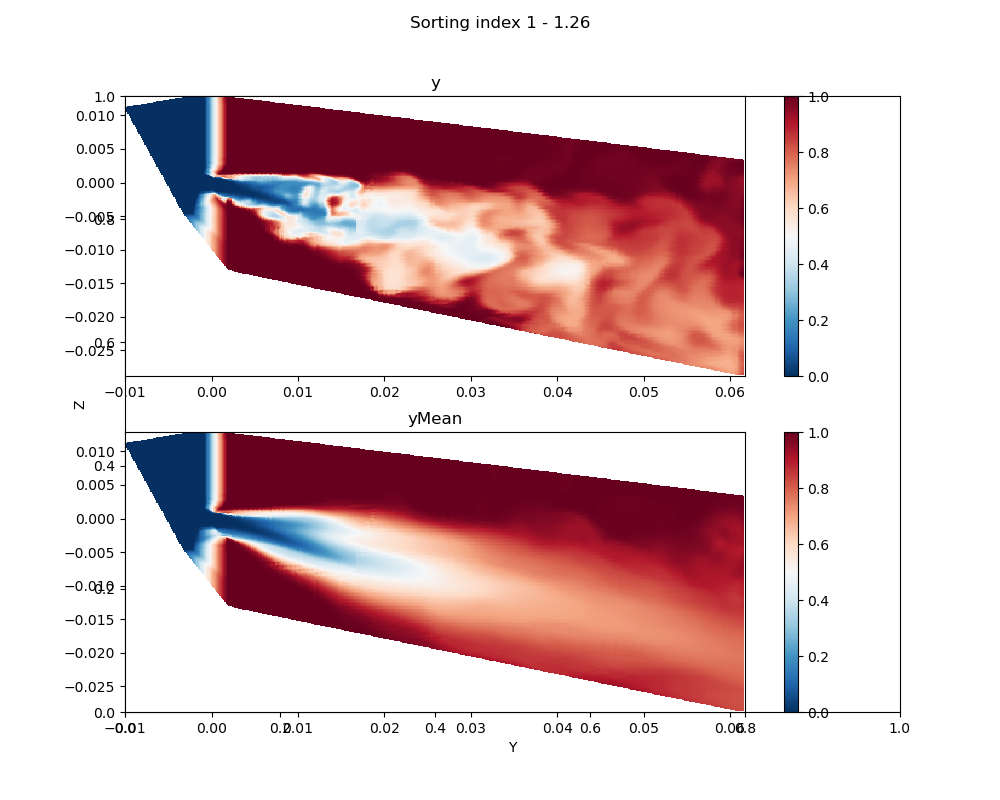

Plotting 1/5


<IPython.core.display.Javascript object>


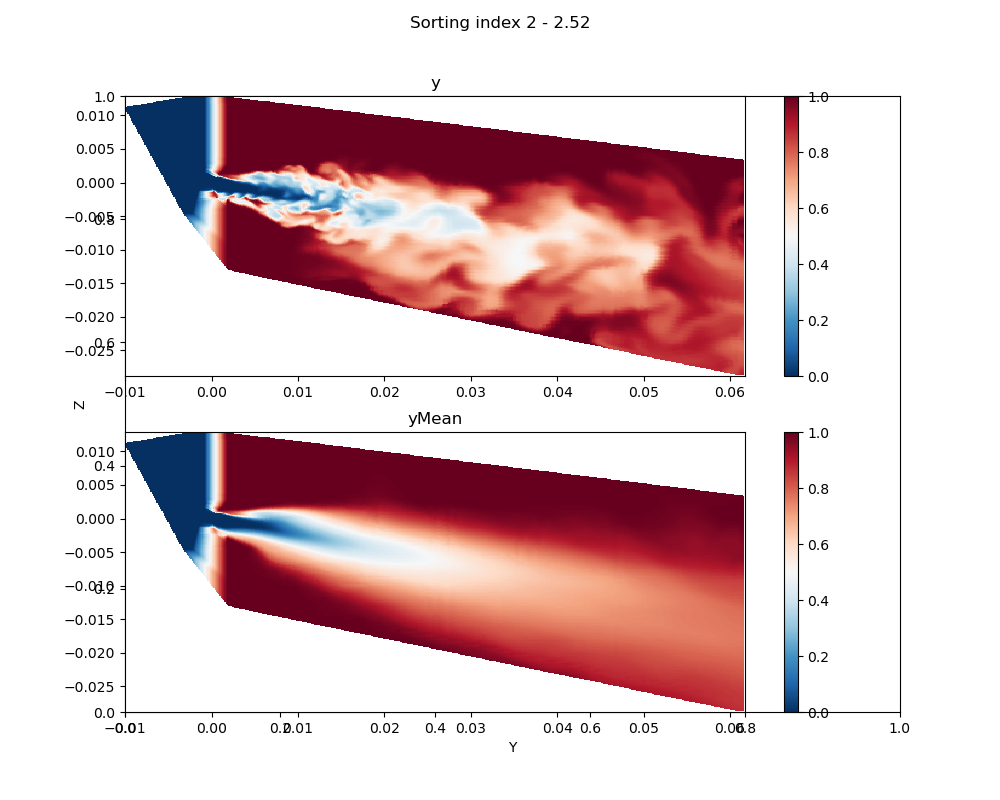

Plotting 2/5


<IPython.core.display.Javascript object>


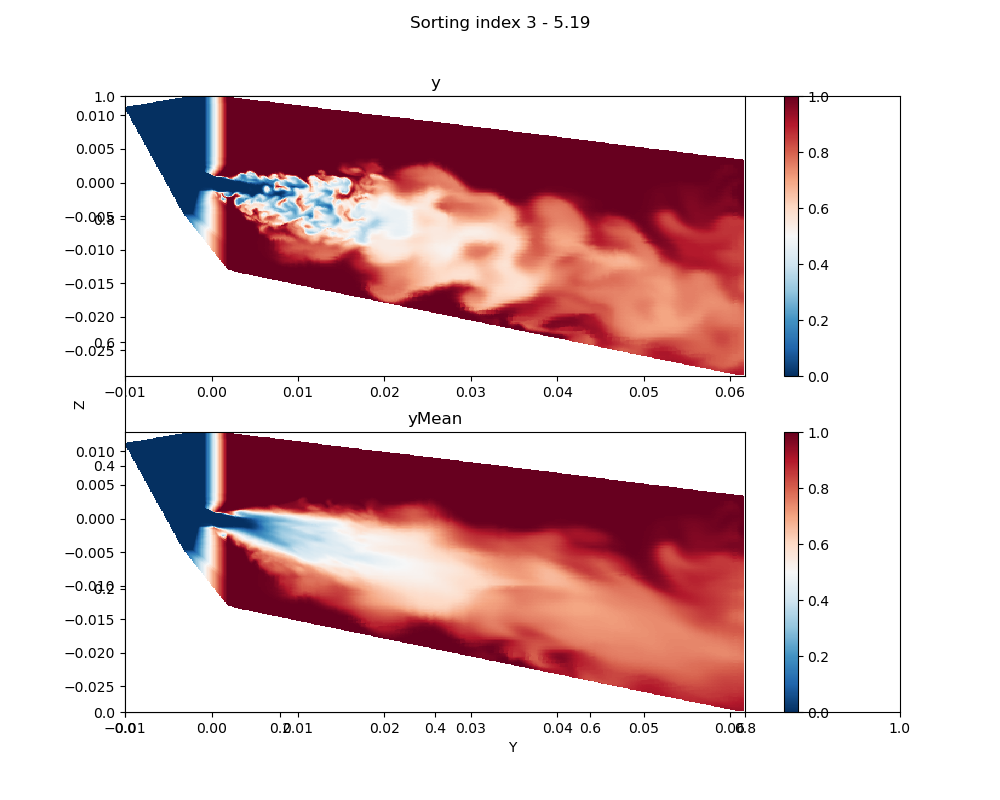

Plotting 3/5


<IPython.core.display.Javascript object>


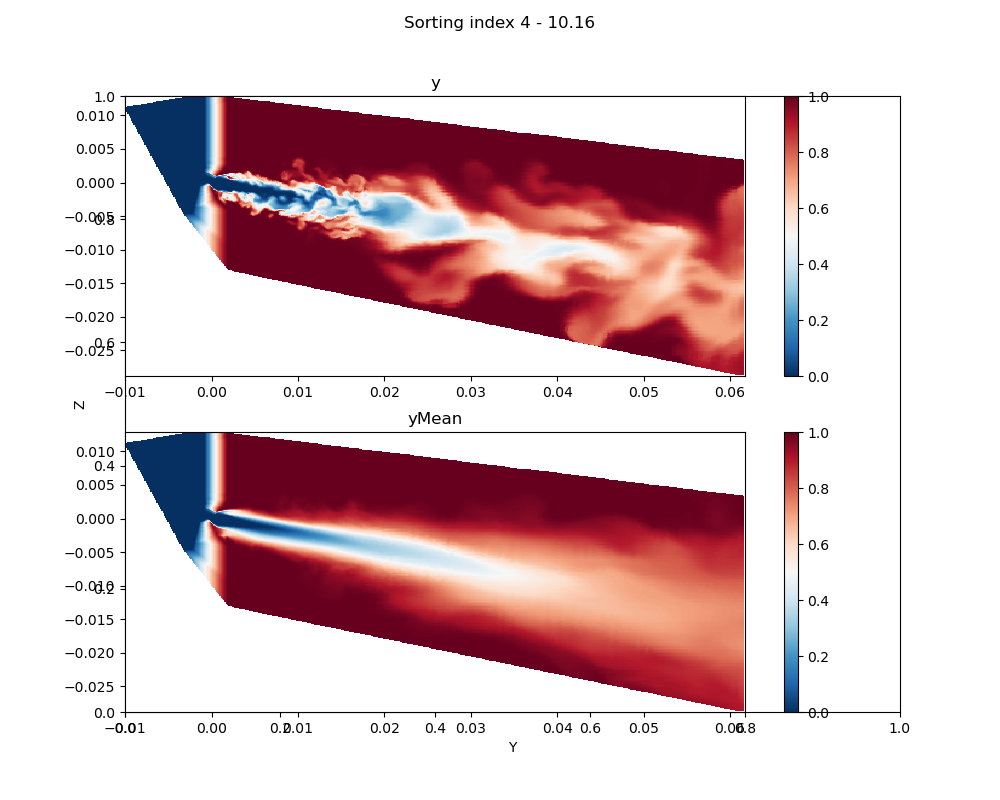

Plotting 4/5


<IPython.core.display.Javascript object>


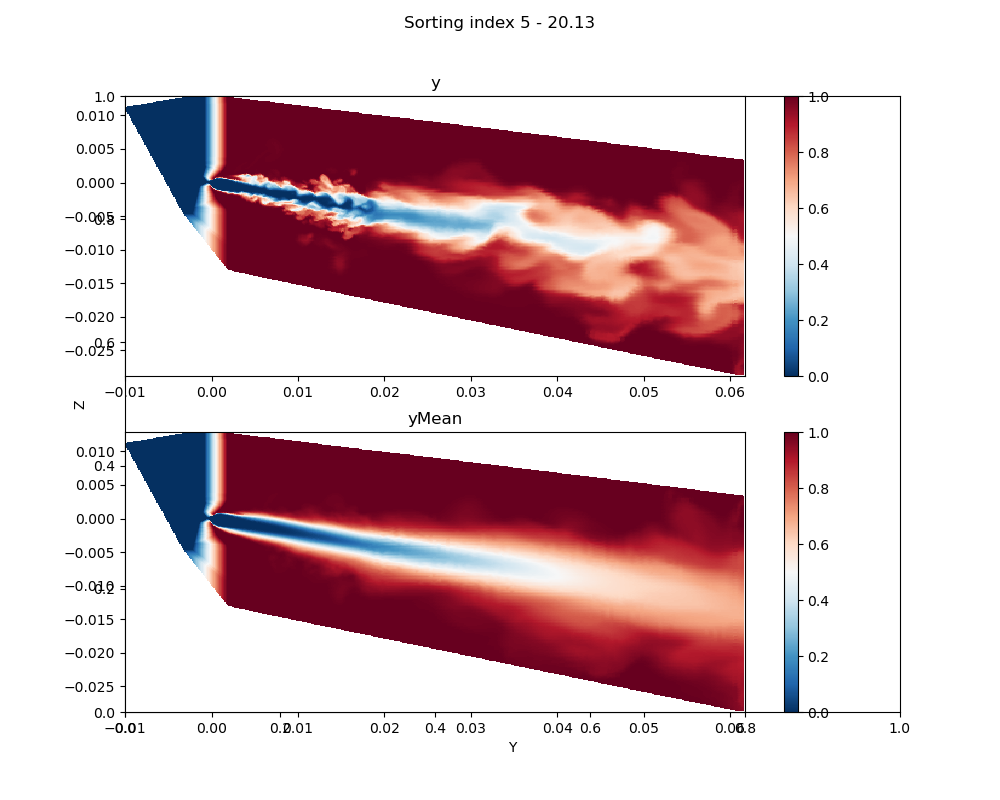

In [47]:
# Pick a variable to plot
varsToPlot = [ V.index('y'), V.index('yMean') ]

# Create a regular grid
xp = np.linspace( xyz_output[0].min(), xyz_output[0].max(), 512 )
yp = np.linspace( xyz_output[1].min(), xyz_output[1].max(), 512 )
Xp, Yp = np.meshgrid(xp, yp)

D_=Di

for i in range(Ds.shape[0]): # Loop over the various sorting indices
    
    print("Plotting %i/%i" % (i,D_.shape[0]))
    
    # Interpolate the data onto the regular grid
    triang = tri.Triangulation(xyz_output[0], xyz_output[1])
    
    # Create figure
    fig=plt.figure(figsize=(10,8))
    plt.suptitle("Sorting index %g - %g" % (keyValues[i],keyDescriptors[i]))
    if plane_norm==xv: 
        plt.xlabel("Y")
        plt.ylabel("Z")
    elif plane_norm==yv:
        plt.xlabel("X")
        plt.ylabel("Z")
    elif plane_norm==zv:
        plt.xlabel("X")
        plt.ylabel("Y")
    
    # Plot all the requested variables side-by-side
    jj=1
    for j in varsToPlot:
        interpolator = tri.LinearTriInterpolator(triang, D_[i,j,:])
        zp = interpolator(Xp, Yp)
    
        ax = fig.add_subplot(len(varsToPlot),1,jj); jj+=1
        cntr1=ax.pcolormesh(-xp, yp, zp, cmap="RdBu_r", shading='nearest')
    
        fig.colorbar(cntr1, ax=ax)
        plt.title(V[j])
    
    plt.show();
    #break

## Calculate L2 norm of differences between interpolated fields
This is used to check for convergence of variables


In [48]:
print(V)

['Cell Type', 'Center:0', 'Center:1', 'Center:2', 'DxDt', 'K', 'M', 'MSave', 'OmegaMin', 'OmegaP', 'ScLimited', 'Sigma', 'T', 'TMean', 'TPrime2Mean', 'U:0', 'U:1', 'U:2', 'UMean:0', 'UMean:1', 'UMean:2', 'UPrime2Mean:0', 'UPrime2Mean:1', 'UPrime2Mean:2', 'UPrime2Mean:3', 'UPrime2Mean:4', 'UPrime2Mean:5', 'V', 'Ybar', 'alphaFrac', 'alphaFracMean', 'alphaFracPrime2Mean', 'alphaSgs', 'd32', 'd32Mean', 'd32Prime2Mean', 'dMdp', 'h', 'k', 'kMean', 'kPrime2Mean', 'muSgs', 'nD', 'nDMean', 'nDPrime2Mean', 'p', 'pMean', 'pPrime2Mean', 'pSat', 'psi2phase', 'resolution', 'rho', 'rhoBar', 'rhoL', 'rhoMean', 'rhoPrime2Mean', 'rhoV', 'rhog', 'theta', 'x', 'xMean', 'xPrime2Mean', 'xbar', 'y', 'yMean', 'yPrime2Mean']


In [58]:
# Reference key for comparison when computing differences between results
kRef = -1
l2 = {}

for j in range(len(V)): # Loop variables
    
    # Get the reference case (highest resolved grid for example)
    ref = Di[kRef,j,:]
    
    # Compute sum of squares of distances from the reference grid
    sumsquares = [ np.nansum( (Di[i,j,:]-ref)**2 ) for i in range(len(keyValues)) ]
    
    # Renormalize by dividing by the sum of squares of the reference grid
    sumsquares = np.array( sumsquares / np.nansum(ref**2) )
    
    # Compute L2-norm by taking square root of sum of squares.
    # Value is already divided by the reference, so it is a fractional representation
    l2[V[j]] = np.sqrt(sumsquares)

# Print all the time-averaged statistics
print('sortingKey :\t',keyDescriptors)
for variable in [v for v in V if ('Mean' in v and not 'Prime2Mean' in v)]:
    print(variable,':\t',np.round(l2[variable]*100,2),'%')

sortingKey :	 [ 1.26  2.52  5.19 10.16 20.13]
TMean :	 [2.45 1.64 2.   1.04 0.  ] %
UMean:0 :	 [81.97 74.41 90.9  61.4   0.  ] %
UMean:1 :	 [43.46 33.23 39.73 21.65  0.  ] %
UMean:2 :	 [59.77 40.7  50.63 28.43  0.  ] %
alphaFracMean :	 [0.61 0.59 0.56 0.4  0.  ] %
d32Mean :	 [12.44 12.27 12.21  6.44  0.  ] %
kMean :	 [244.16 222.45 203.08  90.7    0.  ] %
nDMean :	 [2146.76  688.58  161.43   79.91    0.  ] %
pMean :	 [0.37 0.36 0.36 0.17 0.  ] %
rhoMean :	 [1.81 1.55 1.98 1.66 0.  ] %
xMean :	 [0.64 0.65 0.63 0.23 0.  ] %
yMean :	 [21.37 14.34 17.42  9.09  0.  ] %


In [57]:
print('sortingKey :\t',keyDescriptors)
for variable in [v for v in V if ('Prime2Mean' in v)]:
    print(variable,':\t',np.round(l2[variable]*100,2),'%')

sortingKey :	 [ 1.26  2.52  5.19 10.16 20.13]
TPrime2Mean :	 [101.99 106.34  91.6   74.38   0.  ] %
UPrime2Mean:0 :	 [ 96.21 101.06 139.57  84.69   0.  ] %
UPrime2Mean:1 :	 [84.92 83.75 76.52 71.21  0.  ] %
UPrime2Mean:2 :	 [ 87.59 119.1  105.22  81.06   0.  ] %
UPrime2Mean:3 :	 [186.44 268.5  290.35 185.39   0.  ] %
UPrime2Mean:4 :	 [ 93.2  112.45  72.57  84.52   0.  ] %
UPrime2Mean:5 :	 [167.69 326.45 456.78 228.1    0.  ] %
alphaFracPrime2Mean :	 [93.21 93.56 97.74 88.96  0.  ] %
d32Prime2Mean :	 [279.67 429.36 105.62  98.04   0.  ] %
kPrime2Mean :	 [319.92 431.9  214.14 134.71   0.  ] %
nDPrime2Mean :	 [14285.9    402.47    99.99    80.29     0.  ] %
pPrime2Mean :	 [688.05 485.   193.96  90.25   0.  ] %
rhoPrime2Mean :	 [108.92 119.53  97.6   89.84   0.  ] %
xPrime2Mean :	 [250.22 229.86 134.85  83.76   0.  ] %
yPrime2Mean :	 [101.97 106.28  91.5   74.37   0.  ] %
